In [71]:
import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import re
import gensim
from gensim.models import Word2Vec

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [72]:
# dataset location
DATASET = "data/prospect-data.csv"

# load dataset into dataframe
data = pd.read_csv(DATASET)

data.head()

,Year,Position,Height,Weight,Drafted,Team,Average Ranking,Name,Description - Corey Pronman,Description - Scott Wheeler,Description - Smaht Scouting,Description - ESPN (Chris Peters),Description - EP Rinkside,Description - EP Rinkside Part 2,Description - The Painted Lines,Description - FCHockey
0,2023,C,69.75,185.0,NaN,NaN,1.0,Connor Bedard,Bedard is a potential franchise-changing No. 1...,Bedard’s statistical profile speaks for itself...,Connor Bedard is an extremely gifted generatio...,One of the most naturally gifted goal scorers ...,NaN,Connor Bedard is the premier prospect in the w...,NaN,NaN
1,2023,C,74.00,187.0,NaN,NaN,2.0,Adam Fantilli,There's so much to love about Fantilli's NHL p...,"Fantilli is a big, strong, powerful center who...",Adam Fantilli has every tool that an NHL team ...,"A 6-foot-2, 200-pound power center with touch,...",NaN,"A fantastic consolation prize, Adam Fantilli w...",NaN,NaN
2,2023,RW,70.00,148.0,NaN,NaN,3.0,Matvei Michkov,Michkov is one of the very best first-year dra...,Michkov is the best Russian prospect since Ale...,"A smart, dynamic goal-scoring winger, Michkov ...","For the last few years, I’ve described Michkov...",NaN,"Statistically, Matvei Michkov is *another* fir...",NaN,NaN
3,2023,C,75.00,194.0,NaN,NaN,4.0,Leo Carlsson,"Carlsson has elite skill, which when combined ...",Though he doesn’t play the game with some of t...,Carlsson has been played extremely well at the...,The buzz is growing (and rightfully so) that C...,NaN,"Oh, look, another first-overall talent. Leo Ca...",NaN,NaN
4,2023,LW,69.75,170.0,NaN,NaN,5.0,Zach Benson,Benson has a ton of creativity and offense in ...,"There were a lot of nights last season, on an ...",While I don’t necessarily see Zach Benson reac...,"An offensive dynamo with deft scoring touch, B...",NaN,Some people are worried about selecting a 5-9 ...,NaN,NaN


In [73]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               402 non-null    int64  
 1   Position                           402 non-null    object 
 2   Height                             402 non-null    float64
 3   Weight                             402 non-null    float64
 4   Drafted                            360 non-null    float64
 5   Team                               360 non-null    object 
 6   Average Ranking                    162 non-null    float64
 7   Name                               402 non-null    object 
 8   Description - Corey Pronman        389 non-null    object 
 9   Description - Scott Wheeler        213 non-null    object 
 10  Description - Smaht Scouting       149 non-null    object 
 11  Description - ESPN (Chris Peters)  229 non-null    object 

In [74]:
# encode position
# TODO: we should keep the positions for when we do clustering
le = preprocessing.LabelEncoder()
le.fit(data['Position'].unique())
data['Position'] = data['Position'].apply(lambda x: le.transform([x])[0])

height_scaler = preprocessing.MinMaxScaler()
data['Height'] = height_scaler.fit_transform(data['Height'].values.reshape(-1, 1))
weight_scaler = preprocessing.MinMaxScaler()
data['Weight'] = weight_scaler.fit_transform(data['Weight'].values.reshape(-1, 1))


data.head()

,Year,Position,Height,Weight,Drafted,Team,Average Ranking,Name,Description - Corey Pronman,Description - Scott Wheeler,Description - Smaht Scouting,Description - ESPN (Chris Peters),Description - EP Rinkside,Description - EP Rinkside Part 2,Description - The Painted Lines,Description - FCHockey
0,2023,0,0.277778,0.278499,NaN,NaN,1.0,Connor Bedard,Bedard is a potential franchise-changing No. 1...,Bedard’s statistical profile speaks for itself...,Connor Bedard is an extremely gifted generatio...,One of the most naturally gifted goal scorers ...,NaN,Connor Bedard is the premier prospect in the w...,NaN,NaN
1,2023,0,0.592593,0.292929,NaN,NaN,2.0,Adam Fantilli,There's so much to love about Fantilli's NHL p...,"Fantilli is a big, strong, powerful center who...",Adam Fantilli has every tool that an NHL team ...,"A 6-foot-2, 200-pound power center with touch,...",NaN,"A fantastic consolation prize, Adam Fantilli w...",NaN,NaN
2,2023,4,0.296296,0.011544,NaN,NaN,3.0,Matvei Michkov,Michkov is one of the very best first-year dra...,Michkov is the best Russian prospect since Ale...,"A smart, dynamic goal-scoring winger, Michkov ...","For the last few years, I’ve described Michkov...",NaN,"Statistically, Matvei Michkov is *another* fir...",NaN,NaN
3,2023,0,0.666667,0.343434,NaN,NaN,4.0,Leo Carlsson,"Carlsson has elite skill, which when combined ...",Though he doesn’t play the game with some of t...,Carlsson has been played extremely well at the...,The buzz is growing (and rightfully so) that C...,NaN,"Oh, look, another first-overall talent. Leo Ca...",NaN,NaN
4,2023,3,0.277778,0.170274,NaN,NaN,5.0,Zach Benson,Benson has a ton of creativity and offense in ...,"There were a lot of nights last season, on an ...",While I don’t necessarily see Zach Benson reac...,"An offensive dynamo with deft scoring touch, B...",NaN,Some people are worried about selecting a 5-9 ...,NaN,NaN


In [75]:
corpus, labels, draft_position, player_position, player_name, height, weight = [], [], [], [], [], [], []

scouting_reports = [
    'Description - Corey Pronman',
    'Description - Scott Wheeler',
    'Description - Smaht Scouting',
    'Description - ESPN (Chris Peters)',
    'Description - EP Rinkside', 
    'Description - EP Rinkside Part 2',
    'Description - The Painted Lines',
    'Description - FCHockey'
]

# create a list of stopwords for player names
player_names = list(data['Name'])
name_stopwords = []
for name in player_names:
  name_split = name.split(' ')
  for part in name_split:
    name_stopwords.append(part.lower())

# remove references to leagues, teams, and nationalities
hockey_words = []
"""
hockey_words = ["usntdp", "ntdp", "development", "program",
                "khl", "shl", "ushl", "ncaa", "ohl", "whl", "qmjhl",
                "sweden", "russia", "usa", "canada", "ojhl", "finland", 
                "finnish", "swedish", "russian", "american", "wisconsin",
                "michigan", "bc", "boston", "london", "bchl", "kelowna",
                "portland", "minnesota", "ska", "frolunda", "sjhl", "college",
                "center", "left", "right", "saginaw", "kelowna"]
"""

# Initialize Python porter stemmer
ps = PorterStemmer()

# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

for index, row in data.iterrows():
  text = ""
  for report in scouting_reports:
    # skip null reports
    if pd.isnull(row[report]):
      continue

    # keep only alpha characters
    r = re.sub('[^a-zA-Z]', ' ', row[report])
    # lower string everything
    r = r.lower()
    # split on spaces
    r = r.split()
    # remove stopwords and any reference to the name of the player
    # TODO: check whether we should initialize stopwords, so we don't call this fuction every time
    r = [word for word in r if word not in stopwords.words('english') and word not in name_stopwords and word not in hockey_words]

    # stem cleansed string
    r = [ps.stem(word) for word in r]
    # lemmatize cleansed string
    #r = [lemmatizer.lemmatize(word) for word in r]

    # remove hockey specific stop words
    #r = [word for word in r if word not in hockey_words]

    # join back on spaces
    r = ' '.join(r)
    text = text + " " + r
  # append to dataset
  corpus.append(text)
  labels.append(row['Team'])
  draft_position.append(row['Drafted'])
  player_position.append(row['Position'])
  player_name.append(row['Name'])
  height.append(row['Height'])
  weight.append(row['Weight'])

# sanity check values
print(f"length of corpus: {len(corpus)}")
print(f"length of labels: {len(labels)}")
print(f"length of draft_position: {len(draft_position)}")
print(f"length of player_position: {len(player_position)}")

print(f"corpus first 5: {corpus[0:5]}")
print(f"labels first 5: {labels[0:5]}")
print(f"draft_position first 5: {draft_position[0:5]}")
print(f"player_position first 5: {player_position[0:5]}")

length of corpus: 402
length of labels: 402
length of draft_position: 402
length of player_position: 402
corpus first 5: [' potenti franchis chang prospect skill shot legit game break attribut abil beat defend one one among best ever seen year old pace display elit skill go allow execut type skill play nhl highli imagin puckhandl creativ passer combin fact wrist shot top tier nhl weapon anywher offens zone make project nightmar nhl coach stop play downsid game frame scout wonder get push wing nhl pushov though play hard physic edg game given success junior center strong skate high compet level think whoever draft tri middl move wing work wing could still potenti kane kucherov type impact franchis statist profil speak point game year old whl two point per game u world doubl underag goal point dread team six goal four game u world underag second time even best hockey goal point world junior game forc way onto first three team torch select camp year old turn juli almost forget goal draft 

In [76]:
X = pd.DataFrame(list(zip(player_name, height, weight, draft_position, player_position, corpus)), columns=['player_name', 'height', 'weight', 'draft_position', 'player_position', 'report'])
Y = labels



# vectorize train data
vectorizer = TfidfVectorizer(analyzer='word', max_df=0.5, min_df=0.04, ngram_range=(1, 3))
X_vect = vectorizer.fit_transform(X['report'])
print(f"shape of X_vect: {X_vect.shape}")

# show the most important words
most_important = pd.DataFrame(X_vect[0].T.todense(),
    	index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
most_important = most_important.sort_values('TF-IDF', ascending=False)
most_important.head(30)

shape of X_vect: (402, 1987)


,TF-IDF
goal,0.232297
per game,0.178266
per,0.168967
ever,0.166364
world,0.154396
got,0.151653
seen,0.126684
finish,0.120095
junior,0.120095
underag,0.117250


Exploring Kmeans now for unsupervised learning

In [81]:
def create_final_vector_embeddings(data, embeddings):
    temp_data = []
    for index, row in enumerate(embeddings):
        temp_data.append(np.concatenate((embeddings[index].toarray()[0], [data['height'].values[index]], [data['weight'].values[index]])))
        #temp_data.append(embeddings[index].toarray()[0])
        #formated_data[index] = np.append(formated_data[index], X_train['weight'].values[index])
    return np.array(temp_data)

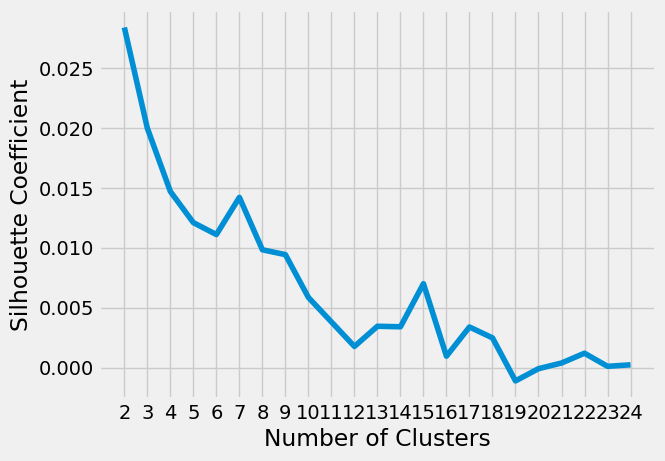

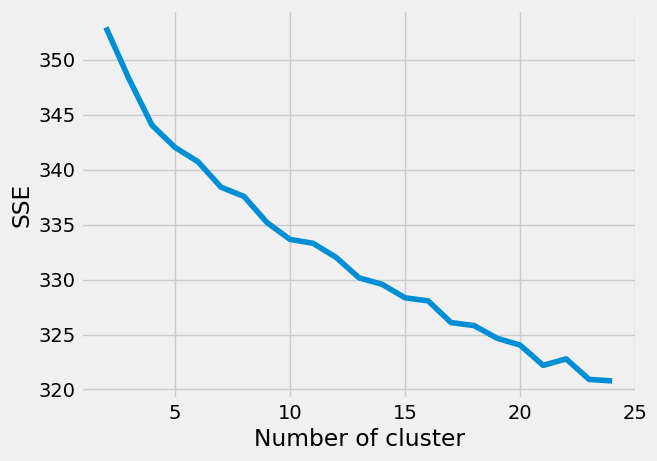

In [82]:
def plot_silhouette_scores(data, start, end, step):
  # A list holds the silhouette coefficients for each k
  silhouette_coefficients = []

  formated_data = data

  sse = {}
  # Notice you start at 2 clusters for silhouette coefficient
  for k in range(start, end, step):
    kmeans = KMeans(n_clusters=k, n_init=2, max_iter=1000)
    kmeans.fit(formated_data)
    score = silhouette_score(formated_data, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse[k] = kmeans.inertia_

  plt.style.use("fivethirtyeight")
  plt.plot(range(start, end, step), silhouette_coefficients)
  plt.xticks(range(start, end, step))
  plt.xlabel("Number of Clusters")
  plt.ylabel("Silhouette Coefficient")
  plt.show()

  plt.plot(list(sse.keys()), list(sse.values()))
  plt.xlabel("Number of cluster")
  plt.ylabel("SSE")
  plt.show()


X_data = create_final_vector_embeddings(X, X_vect)
plot_silhouette_scores(X_data, 2, 25, 1)

The extremely low silhouette score implies there is a lot of overlap in classification of values. There might have to be some more data massaging in order to get this value higher

In [83]:
SELECTED_CLUSTERS = 7

In [84]:
# use the number of clusters found to be the best in graph above
kmeans = KMeans(n_clusters=SELECTED_CLUSTERS, n_init = 5)
kmeans.fit(X_data)

X['label'] = kmeans.predict(X_data)

In [85]:
# show the top words for each cluster that was created
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(X_vect, X.label, vectorizer.get_feature_names_out(), 15)


Cluster 0
center,afraid,quickli,hockey sens,work hard,seem,penalti,fnd,playmak,pretti,agil,step,releas,smart,danger

Cluster 1
upsid,foot,aggress,two way,attack,smart,close,guy,move puck,frame,minut,read,gap,mobil,defenseman

Cluster 2
develop,enough,talent,attack,middl,would,got,danger,center,round,pace,winger,playmak,six,goal

Cluster 3
defens zone,long,close,decis,pair,transit,top four,four,attack,blue line,mobil,blue,gap,defenceman,defenseman

Cluster 4
along,big man,win,quickli,glove,frame,protect,effort,check,creas,reach,save,goaltend,man,goali

Cluster 5
enough,got,make play,finish,rooki,winger,chl,playmak,goal score,releas,score goal,goal scorer,ohl,scorer,goal

Cluster 6
two way,drive,middl,world,frame,centr,protect,playmak,foot,pro,got,goal,winger,six,center


Index(['player_name', 'height', 'weight', 'draft_position', 'player_position',
       'report', 'label'],
      dtype='object')
      player_name    height    weight  draft_position  player_position  \
0   Connor Bedard  0.277778  0.278499             NaN                0   
1   Adam Fantilli  0.592593  0.292929             NaN                0   
2  Matvei Michkov  0.296296  0.011544             NaN                4   
3    Leo Carlsson  0.666667  0.343434             NaN                0   
4     Zach Benson  0.277778  0.170274             NaN                3   

                                              report  label  
0   potenti franchis chang prospect skill shot le...      5  
1   much love nhl project got huge frame skate we...      6  
2   one best first year draft elig ever seen insi...      2  
3   elit skill combin frame strong motor allow go...      6  
4   ton creativ offens game make high end skill p...      2  


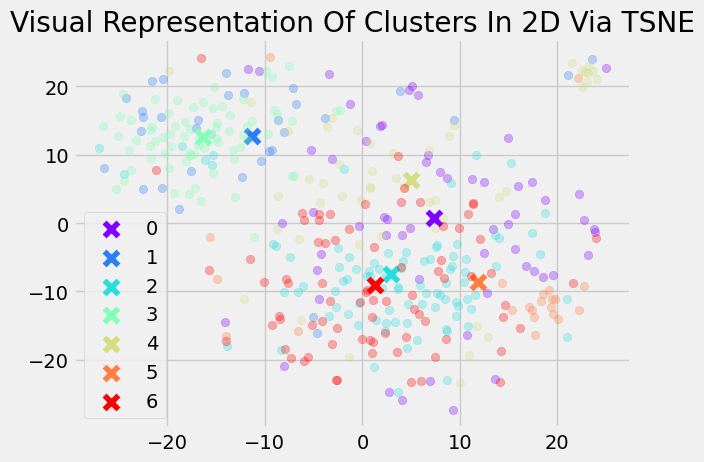

In [86]:
def visualize_results(data):
    import plotly.express as px

    print(data.columns)
    print(data.head())

    #visualize mappings via treemap
    result_summary = pd.pivot_table(data, index=['label', 'player_name'],  aggfunc='count').reset_index().rename(columns={'draft_position':'count'})
    result_treemap = result_summary
    fig = px.treemap(result_treemap,path=['label', 'player_name'],values='count')
    fig.show()

    tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
    vis_dims2 = tsne.fit_transform(X_vect)

    x = [x for x, y in vis_dims2]
    y = [y for x, y in vis_dims2]

    color = cm.rainbow(np.linspace(0, 1, len(data.label.unique())))
    for category, color in enumerate(color):
        xs = np.array(x)[data.label == category]
        ys = np.array(y)[data.label == category]
        plt.scatter(xs, ys, color=color, alpha=0.3)

        avg_x = xs.mean()
        avg_y = ys.mean()

        plt.scatter(avg_x, avg_y, marker="x", color=color, s=100, label=category)
    plt.title("Visual Representation Of Clusters In 2D Via TSNE")
    plt.legend()

visualize_results(X)

In [87]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

# use the number of clusters found to be the best in graph above
dbscan = DBSCAN(eps=10).fit(X_data)
print(dbscan.labels_)

clustering = AgglomerativeClustering().fit(X_data)
print(clustering.labels_)
#X_train['label'] = dbscan.labels_



visualize_results(X)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


ImportError: cannot import name 'rng_integers' from 'scipy._lib._util' (c:\Users\Ryan\anaconda3\lib\site-packages\scipy\_lib\_util.py)